Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on Airbnb listings for six major U.S. cities. The competition's original goal was to use available attributes to predict listing price. However, the dataset can be adjusted to predict other variables as well.

In this notebook, the dataset will be used for practicing classification techniques on two binned versions of the review_scores_rating variable explored previously.

### Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

from plotnine import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def EncodeCategory(col_to_encode):
    distinct_cats = col_to_encode.unique()
    encode_list = []
    i = 1
    for cat in distinct_cats:
        encode_list.append([cat,i])    
        i += 1
    return(encode_list)

***

# Data Preparation Part 1

<i><b>10 pts.</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.</i>

In [3]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

id  log_price property_type        room_type  \
0   6901257   5.010635     Apartment  Entire home/apt   
1   6304928   5.129899     Apartment  Entire home/apt   
2   7919400   4.976734     Apartment  Entire home/apt   
3  13418779   6.620073         House  Entire home/apt   
4   3808709   4.744932     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
3  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
4  {TV,Internet,"Wireless Internet","Air conditio...             2        1.0   

   bed_type cancellation_policy  cleaning_fee city  \
0  Real Bed              strict          True  NYC   
1  Real Bed              strict          True  NYC   
2  Real Bed            moderate          True  NYC   
3  Real Bed            flexible          True   SF   
4  Real Bed            moderate          True   DC   

                                         description first_review  \
0  Beautiful, sunlit brownstone 1-bedroom in the ...   2016-06-18   
1  Enjoy travelling during your stay in Manhattan...   2017-08-05   
2  The Oasis comes complete with a full backyard ...   2017-04-30   
3  This light-filled home-away-from-home is super...          NaN   
4  Cool, cozy, and comfortable studio located in ...   2015-05-12   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      t                NaN  2012-03-26   
1                    t                      f               100%  2017-06-19   
2                    t                      t               100%  2016-10-25   
3                    t                      t                NaN  2015-04-19   
4                    t                      t               100%  2015-03-01   

  instant_bookable last_review   latitude   longitude  \
0                f  2016-07-18  40.696524  -73.991617   
1                t  2017-09-23  40.766115  -73.989040   
2                t  2017-09-14  40.808110  -73.943756   
3                f         NaN  37.772004 -122.431619   
4                t  2017-01-22  38.925627  -77.034596   

                                       name     neighbourhood  \
0            Beautiful brownstone 1-bedroom  Brooklyn Heights   
1  Superb 3BR Apt Located Near Times Square    Hell's Kitchen   
2                          The Garden Oasis            Harlem   
3        Beautiful Flat in the Heart of SF!      Lower Haight   
4                Great studio in midtown DC  Columbia Heights   

   number_of_reviews  review_scores_rating  \
0                  2                 100.0   
1                  6                  93.0   
2                 10                  92.0   
3                  0                   NaN   
4                  4                  40.0   

                                       thumbnail_url  zipcode  bedrooms  beds  
0  https://a0.muscache.com/im/pictures/6d7cbbf7-c...    11201       1.0   1.0  
1  https://a0.muscache.com/im/pictures/348a55fe-4...    10019       3.0   3.0  
2  https://a0.muscache.com/im/pictures/6fae5362-9...    10027       1.0   3.0  
3  https://a0.muscache.com/im/pictures/72208dad-9...  94117.0       2.0   2.0  
4                                                NaN    20009       0.0   1.0

In [5]:
df['price'] = np.exp(df['log_price'])
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df[['grade', 'review_scores_rating']].head()

grade  review_scores_rating
0     A                 100.0
1     A                  93.0
2     A                  92.0
3   NaN                   NaN
4     F                  40.0

In [14]:
# Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
df_ratings.drop_duplicates(inplace=True)
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating', 'price']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

In [7]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
# Impute Missing Value of for 100% Host Response Rate for Row 48194 - Private Room in Apartment
df_imputed["host_response_rate"][df_imputed["host_response_rate"].isna()] = 1.0
df_imputed[ints] = df_imputed[ints].astype(np.int64)

In [8]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

# Create altnerative target variable grade_grouped
new_grades = {
    'A':'A',
    'B':'<A',
    'C':'<A',
    'D':'<A',
    'F':'<A'
}
df_imputed['grade_grouped'] = df_imputed['grade'].map(new_grades)

In [9]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

Removed columns that are not meaningful in a modeling context (i.e., index,id), redundant with newly engineered features (i.e., amenities, description), or are likenly not useful in predicting the target variable grade_grouped.

In [16]:
# delete useless columns
df_logistic = df_imputed.drop(['index','id','amenities','description','zipcode','description_length',
                               'latitude','longitude','name','neighbourhood','review_scores_rating','thumbnail_url',
                               'zipcode'], axis=1)

# delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

# Remove factor with unncessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

One-Hot Encode Categorical Variables with multiple levels.

In [17]:
categorical_vars = ['room_type','bed_type','cancellation_policy','city']

# Create Dummy Variables
multiCategorical_vars = ['city','cancellation_policy','bed_type','room_type']

dummy_df = pd.get_dummies(df_logistic[multiCategorical_vars], drop_first = True)
df_final = pd.concat([df_logistic, dummy_df], axis=1)

# Delete non-dummy categorical variables
for x in categorical_vars:
    if x in df_final:
        del df_final[x]

***

# Data Preparation Part 2

<i><b>5 pts.</b> Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).</i>

In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 37 columns):
log_price                              57389 non-null float64
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
cleaning_fee                           57389 non-null bool
host_has_profile_pic                   57389 non-null bool
host_identity_verified                 57389 non-null bool
host_response_rate                     57389 non-null float64
instant_bookable                       57389 non-null bool
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
price                                  57389 non-null float64
length_amenities                       57389 non-null int64
internet                               57389 non-null bool
TV                                     57389 non

In [14]:
df_final.describe()

log_price  accommodates     bathrooms  host_response_rate  \
count  57389.000000  57389.000000  57389.000000        57389.000000   
mean       4.749232      3.218247      1.225967            0.952633   
std        0.668700      2.144154      0.561473            0.122000   
min        0.000000      1.000000      0.000000            0.000000   
25%        4.304065      2.000000      1.000000            0.940000   
50%        4.700480      2.000000      1.000000            1.000000   
75%        5.164786      4.000000      1.000000            1.000000   
max        7.600402     16.000000      8.000000            1.000000   

       number_of_reviews      bedrooms          beds  length_amenities  \
count       57389.000000  57389.000000  57389.000000      57389.000000   
mean           26.957326      1.260904      1.737546         18.357943   
std            41.043449      0.841280      1.265311          6.907464   
min             1.000000      0.000000      0.000000          1.000000   
25%             3.000000      1.000000      1.000000         14.000000   
50%            11.000000      1.000000      1.000000         18.000000   
75%            33.000000      1.000000      2.000000         22.000000   
max           605.000000     10.000000     18.000000         77.000000   

       host_since_days  city_Chicago       city_DC       city_LA  \
count     57389.000000  57389.000000  57389.000000  57389.000000   
mean       1373.129380      0.055899      0.071442      0.299465   
std         662.667741      0.229729      0.257564      0.458028   
min         167.000000      0.000000      0.000000      0.000000   
25%         851.000000      0.000000      0.000000      0.000000   
50%        1312.000000      0.000000      0.000000      0.000000   
75%        1841.000000      0.000000      0.000000      1.000000   
max        3663.000000      1.000000      1.000000      1.000000   

           city_NYC       city_SF  cancellation_policy_moderate  \
count  57389.000000  57389.000000                  57389.000000   
mean       0.436111      0.087944                      0.287355   
std        0.495906      0.283215                      0.452532   
min        0.000000      0.000000                      0.000000   
25%        0.000000      0.000000                      0.000000   
50%        0.000000      0.000000                      0.000000   
75%        1.000000      0.000000                      1.000000   
max        1.000000      1.000000                      1.000000   

       cancellation_policy_strict  cancellation_policy_super_strict_30  \
count                57389.000000                         57389.000000   
mean                     0.484884                             0.001446   
std                      0.499776                             0.038003   
min                      0.000000                             0.000000   
25%                      0.000000                             0.000000   
50%                      0.000000                             0.000000   
75%                      1.000000                             0.000000   
max                      1.000000                             1.000000   

       cancellation_policy_super_strict_60  bed_type_Couch  bed_type_Futon  \
count                         57389.000000    57389.000000    57389.000000   
mean                              0.000174        0.002771        0.010560   
std                               0.013199        0.052564        0.102216   
min                               0.000000        0.000000        0.000000   
25%                               0.000000        0.000000        0.000000   
50%                               0.000000        0.000000        0.000000   
75%                               0.000000        0.000000        0.000000   
max                               1.000000        1.000000        1.000000   

       bed_type_Pull-out Sofa  bed_type_Real Bed  room_type_Private room  \
count            57389.000000       5738

The original variable price was not including in the model. Instead, there was log price, likely made to compress the outliers of price (for example, there was an entire island for rent). We exponentiated log price to get back the original price variable.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28b122b0>]],
      dtype=object)

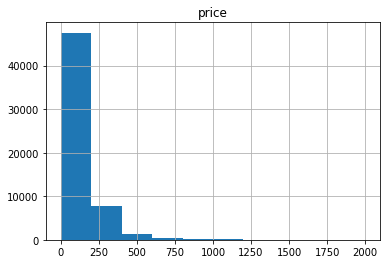

In [20]:
df_final.hist(column='price')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0E2BB77C8>]],
      dtype=object)

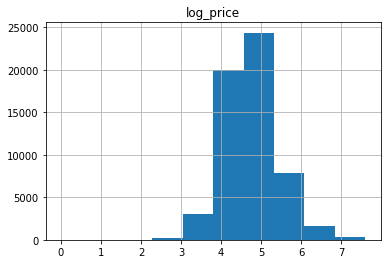

In [15]:
df_final.hist(column='log_price')

As pictured above, the log price has a much more normal distribution. Another attribute we created is the host_since_days, a calculation of how many days a host has been active, defined as the days they became a host subtracted from the date the dataset was made publcally available.

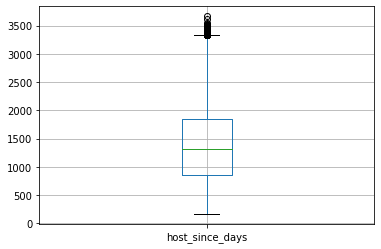

In [21]:
df_final.boxplot(column='host_since_days')

This appears to be right-skewed, with a number of outliers. Some of the hosts look to have been active for a very long time. 

We also created a variable called length_amenities. The original amenities variable was a list of all the reported amenties. We wanted to see if there was a correlation between the length of this list and the overall grade of the property.

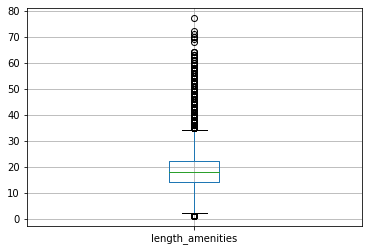

In [22]:
df_final.boxplot(column='length_amenities')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a0af198>]],
      dtype=object)

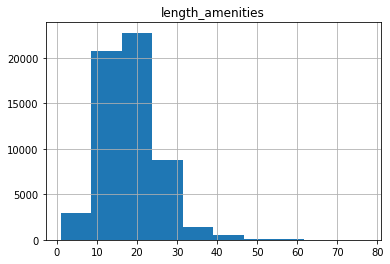

In [23]:
df_final.hist(column='length_amenities')

There is an apparent right skew. There are a number of people who have very long lists of amenities.
**For the purpose of our first classification task**, we have created a grade_grouped target variable to identify potential hosts that may be targeted for AirBnb's superhost program if they have at least 90% for their rating review scores. We grouped all grades under an A as being less than an A because most people in the dataset have an A rating and we wanted to mitigate the class imbalance and create a binary variable to predict.

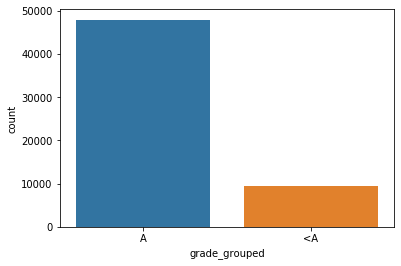

In [24]:
sns.countplot(data=df_imputed, x = 'grade_grouped')

For the grade_grouped target variable, there is a heavy imbalance of classes with 47,897 (83.5%) instances in the dataset reciving a rating review score of 90% or higher. On the other hand, only 9,492 instances recieved a rating review score lower than 90%. Although our EDA, shows a clear separation between the classes of A and <A compared to the 96% cutoff with the superuser variable. With this heavy imbalance, we will attempt to build our classification models using prior probabilities to optimize model performance and prediction accuracy.

**For the purpose of the second classification task**, we decided to subset our dataset based on all listing records that recieved an A or at least 90% on their review scores rating. From there we will use the superuser target variable to further investigate what separates good AirBnb listings (at least 90%) and exceptional listings (at least 96%, the minimum overall rating from reviews to be eligible for the Superhost program). This task will be performed with the dataset named df_superuser_subset.

In [25]:
df_superuser_subset = df_final.loc[df_imputed['grade'] == 'A']
df_superuser_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47897 entries, 0 to 57388
Data columns (total 37 columns):
log_price                              47897 non-null float64
accommodates                           47897 non-null int64
bathrooms                              47897 non-null float64
cleaning_fee                           47897 non-null bool
host_has_profile_pic                   47897 non-null bool
host_identity_verified                 47897 non-null bool
host_response_rate                     47897 non-null float64
instant_bookable                       47897 non-null bool
number_of_reviews                      47897 non-null int64
bedrooms                               47897 non-null int64
beds                                   47897 non-null int64
price                                  47897 non-null float64
length_amenities                       47897 non-null int64
internet                               47897 non-null bool
TV                                     47897 non

False    27558
True     20339
Name: superuser, dtype: int64

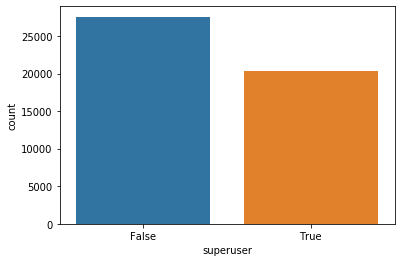

In [26]:
sns.countplot(data=df_superuser_subset, x = 'superuser')
df_superuser_subset['superuser'].value_counts()
#adjust classification penalty against true, class weights, over/under sample

For the superuser target variable in df_superuser_subset, there is a slight imbalance of classes with 27,558 (57.5%) instances in the dataset reciving a rating review score between 90-96%. On the other hand, there are 20,339 instances that recieved a rating review score of 96% and higher.

In [27]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 37 columns):
log_price                              57389 non-null float64
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
cleaning_fee                           57389 non-null bool
host_has_profile_pic                   57389 non-null bool
host_identity_verified                 57389 non-null bool
host_response_rate                     57389 non-null float64
instant_bookable                       57389 non-null bool
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
price                                  57389 non-null float64
length_amenities                       57389 non-null int64
internet                               57389 non-null bool
TV                                     57389 non

Finally we wanted to get valuable information from the amenities list and created boolean variables about whether or not a property had internet, TV, air conditioning, parking, or a kitchen.

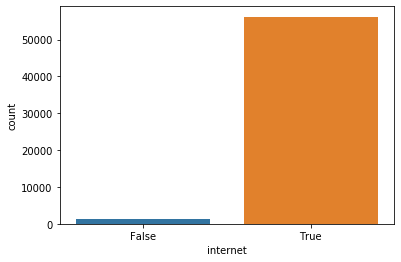

In [29]:
sns.countplot(df_final.internet)

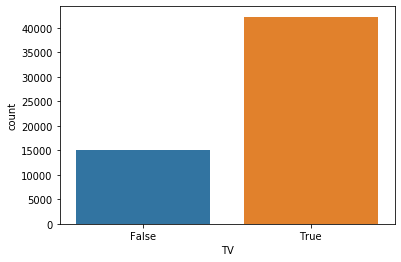

In [30]:
sns.countplot(df_final.TV)

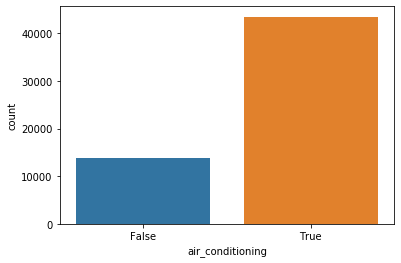

In [31]:
sns.countplot(df_final.air_conditioning)

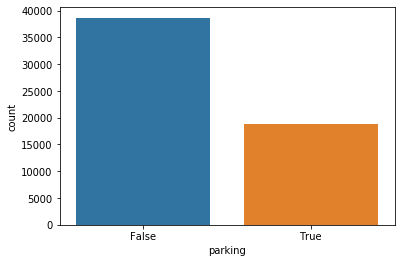

In [32]:
sns.countplot(df_final.parking)

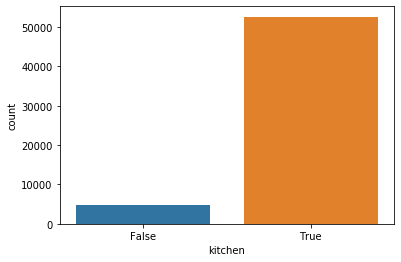

In [33]:
sns.countplot(df_final.kitchen)

***

# Modeling and Evaluation 1

<i><b>10 pts.</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.</i>

For our first classification task with the grade_grouped target responsible, we aim to investigate potential AirBnb hosts that should be targeted for the Superhost program. We will prioritize high precision for the grade_grouped target variable since there is a large majority for the class with an A grade for their ratings review score. With an abundance of instances for this class, we would like to minimize the false positives because we want to correctly determine which AirBnb hosts are ideal for the Superhost program. We also may want to evaluate our model with the F-measure to minimize the false negative predictions because we do not want to miss out on superb hosts that would benefit from the Superhost program. We want to penalize the misclassification of listings with an actual grade of less than A to A more than the misclassification of a listing with an actual grade of A to a grade less than A in the classification models for this first task.
    
For our second classification task with the superuser target variable in df_superuser_subset, we will look into overall classification accuracy since the penalty cost for false negatives and false positives are roughly the same since the classes are not heavily imbalanced. We may also want to investigate precision in the models for this task as well since we want to explore how Superhosts (>=96%) are differentiated from good AirBnb hosts (90-95%).

***

# Modeling and Evaluation 2

<i><b>10 pts.</b> Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.</i>

The method we will use to divide the data into training and test splits will be stratified 10-fold cross validation due to our large class imbalance in the grade_grouped target response variable; it is an approximately 5:1 ratio on A vs everything B and lower. With stratified 10-fold cross validation, each fold will be approximately representative of the ratio of classes as the full dataset. In other words, each of the 10 splits of the complete dataset will contain roughly the same percentage of each class from our grade_grouped target response variable.

With a stratified K-fold cross validation technique, we avoid high variance issues of a holdout method while benefiting from the bias and variance reduction of K-fold cross validation. The additional stratification of our data splits will address the class imbalance issue in our dataset. We will use this data split technique for both tasks since there is class imbalance present in both datasets, even though the second classification task on the superhost target response variable is only slighltly imbalanced, at an approximate 1.35:1 ratio on False vs True.

### Task 1: grade_grouped target response

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt

# Task 1: grade_grouped target response variable
# separate response variable from training data
X1 = df_final.drop(['superuser','grade_grouped'],axis=1)
y1 = df_final['grade_grouped']

yhat1 = np.zeros(y1.shape) # will be filled with the predictions
y1 = y1.replace({'A':True, '<A':False})


# Scale data
scl = StandardScaler()
X1 = scl.fit_transform(X1)

# Create CV iterator
cv = StratifiedKFold(n_splits=10)

# Iterate through CV and get predictions
#for train, test in cv.split(X1,y1):
#    clf.fit(X1[train],y1[train])
#    yhat1[test] = clf.predict(X1[test]) 

### Task 2: superuser target response

In [23]:
# Task 2: superuser target response in df_superuser_subset
# separate response variable from training data
X2 = df_superuser_subset.drop(['superuser','grade_grouped'],axis=1)
y2 = df_superuser_subset['superuser']
yhat2 = np.zeros(y2.shape) # will be filled with the predictions

# Scale data
scl = StandardScaler()
X2 = scl.fit_transform(X2)

# Create CV iterator
cv = StratifiedKFold(n_splits=10)

# Iterate through CV and get predictions
#for train, test in cv.split(X2,y2):
#    clf.fit(X2[train],y2[train])
#    yhat2[test] = clf.predict(X2[test]) 

***

# Modeling and Evaluation 3

<i><b>20 pts.</b> Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!</i>

In [24]:
#RF, KNN regression, logistic regression

## Logistic Regression

In [34]:
#logistic regression prep
df_logistic = df_imputed.drop(['index', 'id', 'log_price', 'amenities', 'description', 'zipcode', 'description',
                      'latitude', 'longitude', 'name', 'neighbourhood', 'review_scores_rating',
                      'thumbnail_url', 'zipcode'], axis=1)
categorical_vars = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
df_logistic[categorical_vars].apply(lambda x: len(x.value_counts()), axis=0)

property_type          32
room_type               3
bed_type                5
cancellation_policy     5
city                    6
dtype: int64

In [35]:
df.property_type.value_counts()

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Train                     2
Cave                      2
Parking Space             1
Island                    1
Lighthouse                1
Casa particular           1
Name: property_type,

In [36]:
#delete property type because too many values 
df_logistic.drop(['property_type'], axis=1, inplace=True)
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 31 columns):
room_type                 57389 non-null category
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57389 non-null float64
host_since                57389 non-null datetime64[ns]
instant_bookable          57389 non-null bool
last_review               57388 non-null datetime64[ns]
number_of_reviews         57389 non-null int64
bedrooms                  57389 non-null int64
beds                      57389 non-null int64
price                     57389 non-null float64
grad

In [37]:
df_logistic.dropna(inplace=True)

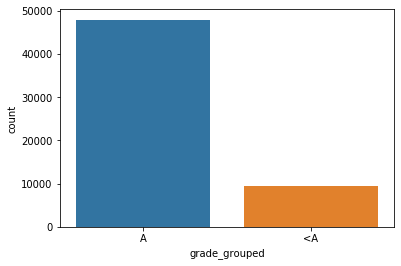

In [38]:
sns.countplot(data=df_logistic, x='grade_grouped')

## Categorical Variable Exploration

* City influences a property's probability of getting an A. For example, you are more likely to get an A in San Francisco and Chicago and less likely to get an A in New York and Boston
* Instant bookable properties were significantly more likely to not get an A. Maybe this is because they do not put as much effort into preparation
* Having an entire property to yourself gave you a better chance at getting an A rating, followed by having a private room, and then having a shared room significantly decreased your probabilities of getting an A
* Having a real bed weirdly seems to be associated with less likelihood of an A. Maybe this is because the expectations are higher
* People with the most strict cancellation policies had the lowest probabilities of getting an A. Maybe this is due to the fact that people can still leave reviews after they cancel and still pay a deposit, or maybe it shows that the host was too strict in other areas 
* Having a cleaning fee is weirdly associated with an increased probability of getting an A. Maybe guests do not like cleaning up after themselves
* Having a profile pic and having your identity verified increases your probability of getting an A
* Based on EDA we can see that the following amenities make a property more likely to get an A:
    * having parking
    * having a pool
    * having a kitchen
    * having air conditioning
    * having a TV 
    * having internet 

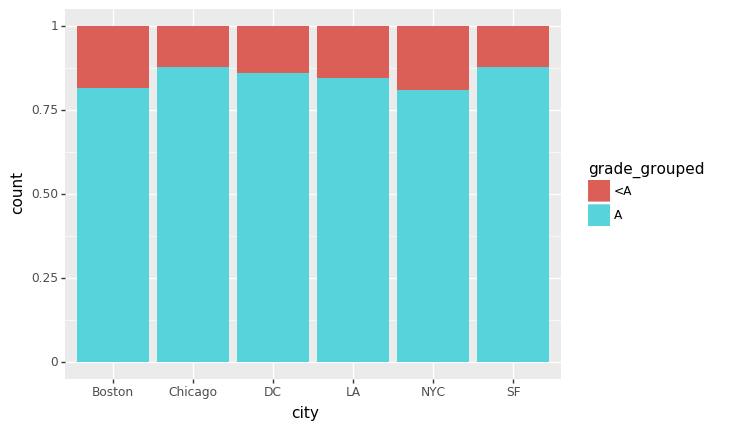

<ggplot: (-9223371903474850160)>

In [30]:
#stacked bar chart of percentages
(ggplot(df_logistic, aes('city', fill='grade_grouped'))
 + geom_bar( position='fill')
)


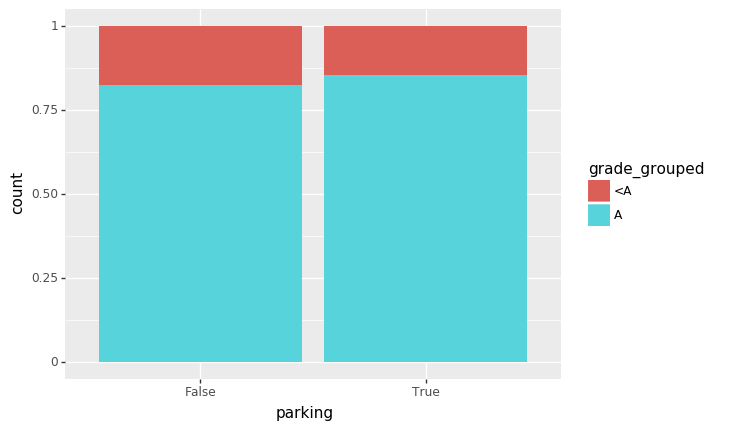

<ggplot: (-9223371903474218140)>

In [31]:
(ggplot(df_logistic, aes('parking', fill='grade_grouped'))
 + geom_bar( position='fill')
)

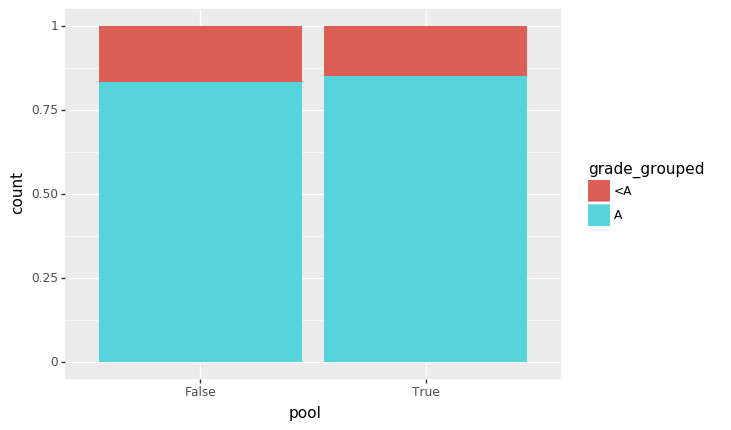

<ggplot: (-9223371903473431872)>

In [32]:
(ggplot(df_logistic, aes('pool', fill='grade_grouped'))
 + geom_bar( position='fill')
)

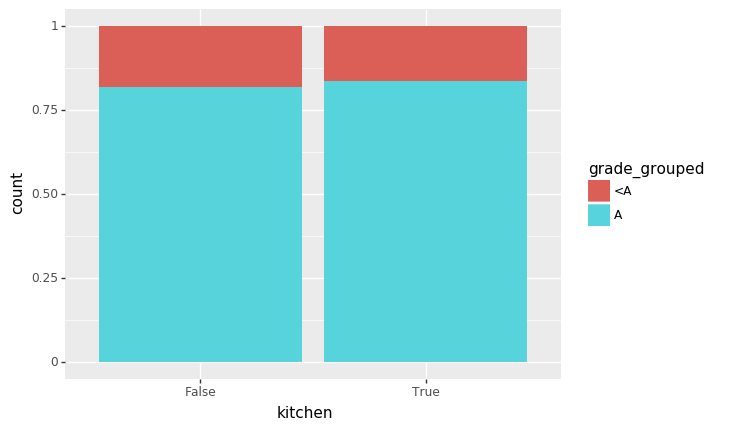

<ggplot: (-9223371903473202404)>

In [33]:
(ggplot(df_logistic, aes('kitchen', fill='grade_grouped'))
 + geom_bar( position='fill')
)

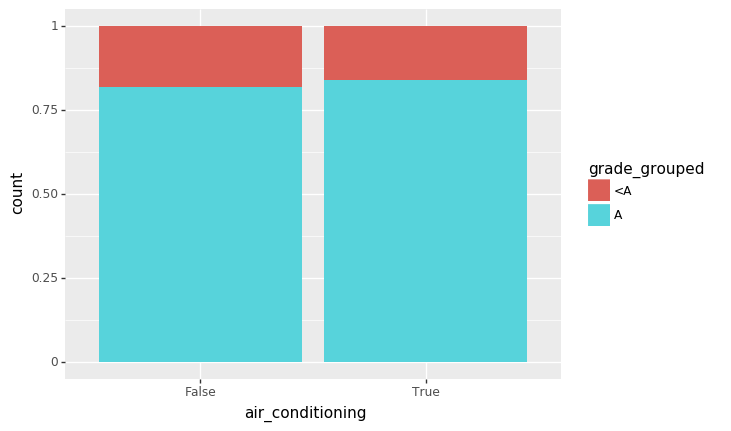

<ggplot: (-9223371903474205568)>

In [34]:
(ggplot(df_logistic, aes('air_conditioning', fill='grade_grouped'))
 + geom_bar( position='fill')
)

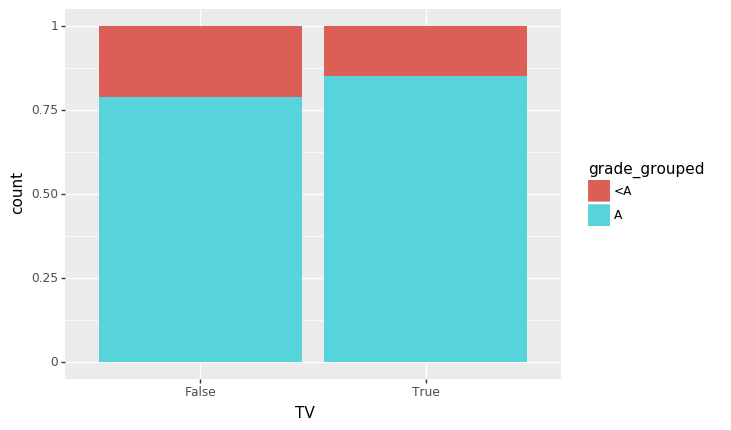

<ggplot: (-9223371903473447084)>

In [35]:
(ggplot(df_logistic, aes('TV', fill='grade_grouped'))
 + geom_bar( position='fill')
)

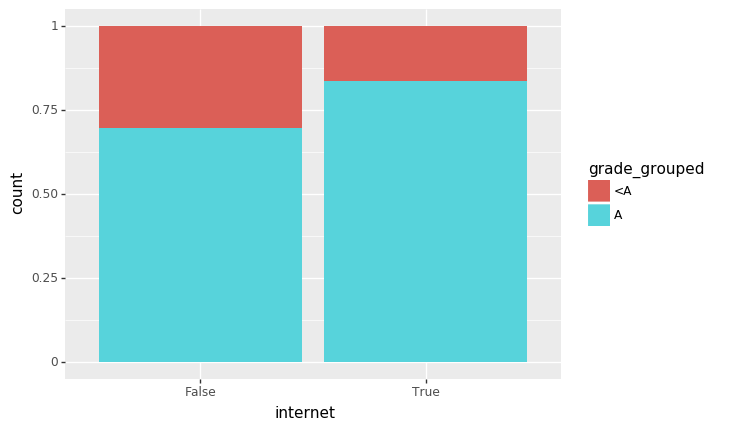

<ggplot: (-9223371903484310468)>

In [36]:
(ggplot(df_logistic, aes('internet', fill='grade_grouped'))
 + geom_bar( position='fill')
)

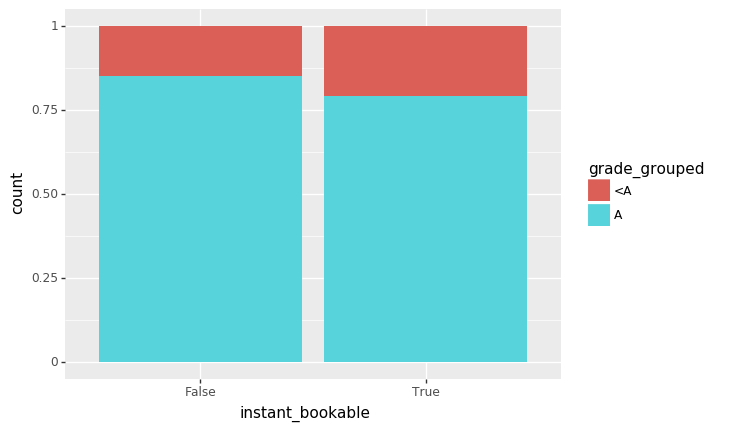

<ggplot: (-9223371903473502552)>

In [37]:
(ggplot(df_logistic, aes('instant_bookable', fill='grade_grouped'))
 + geom_bar( position='fill')
)

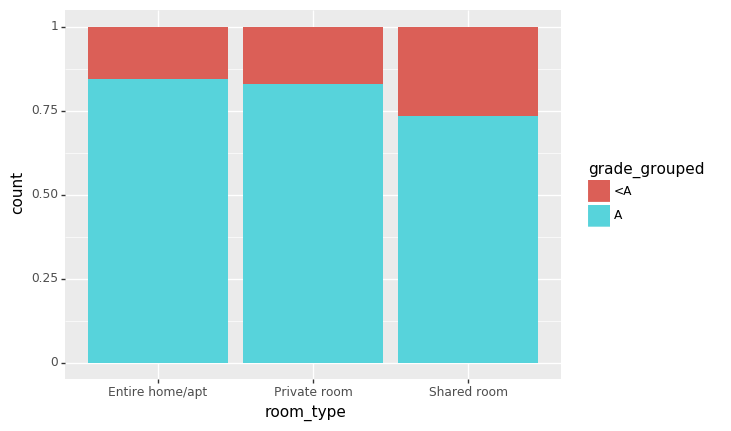

<ggplot: (-9223371903474880672)>

In [38]:
(ggplot(df_logistic, aes('room_type', fill='grade_grouped'))
 + geom_bar( position='fill')
)


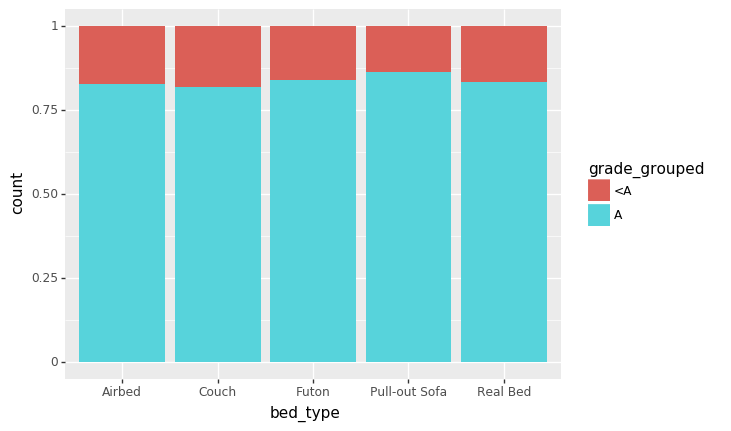

<ggplot: (-9223371903474496296)>

In [39]:
(ggplot(df_logistic, aes('bed_type', fill='grade_grouped'))
 + geom_bar( position='fill')
)

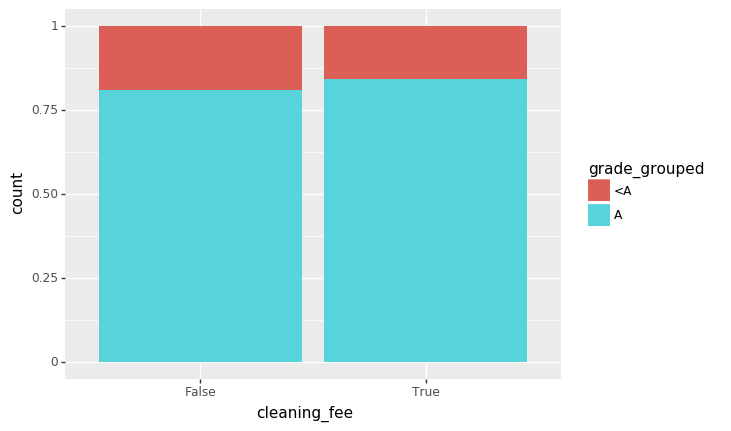

<ggplot: (-9223371903474539024)>

In [40]:
(ggplot(df_logistic, aes('cleaning_fee', fill='grade_grouped'))
 + geom_bar( position='fill')
)

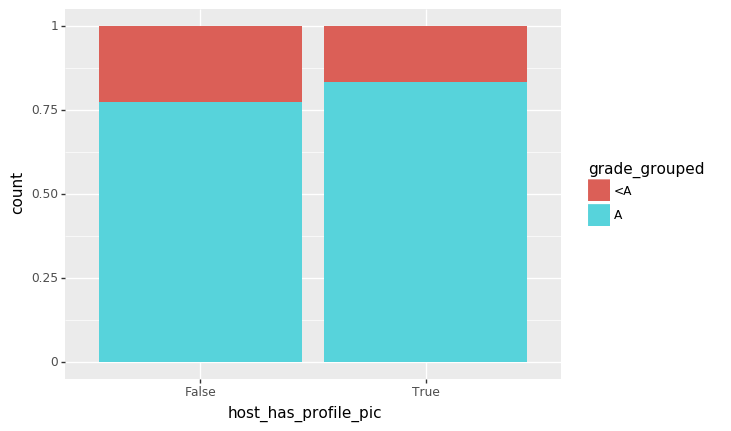

<ggplot: (-9223371903483525884)>

In [41]:
(ggplot(df_logistic, aes('host_has_profile_pic', fill='grade_grouped'))
 + geom_bar( position='fill')
)

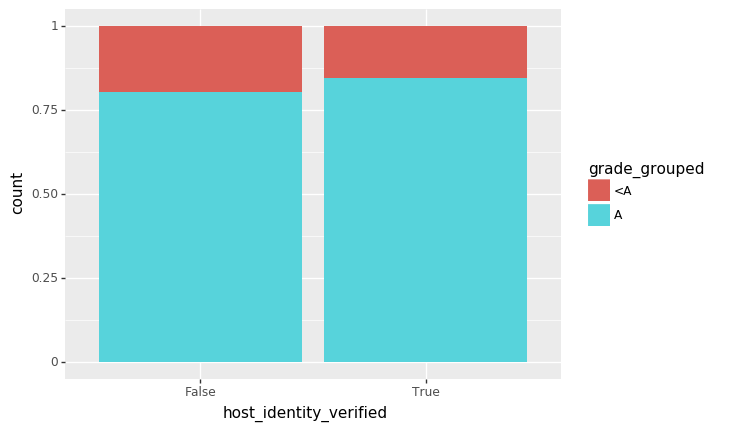

<ggplot: (-9223371903483496776)>

In [42]:
(ggplot(df_logistic, aes('host_identity_verified', fill='grade_grouped'))
 + geom_bar( position='fill')
)

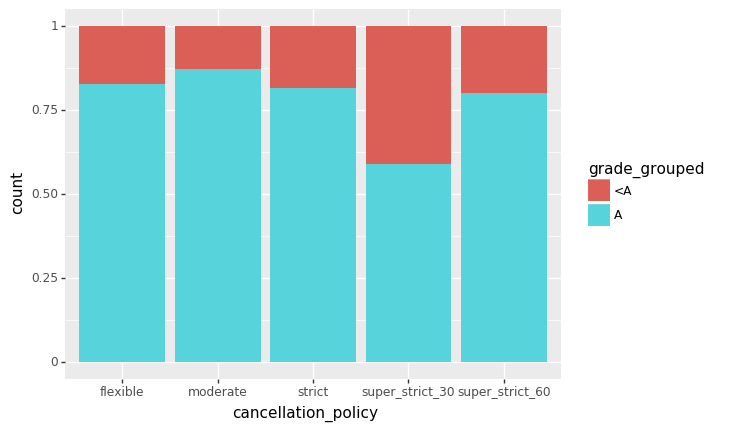

<ggplot: (-9223371903482204968)>

In [43]:
(ggplot(df_logistic, aes('cancellation_policy', fill='grade_grouped'))
 + geom_bar( position='fill')
)


# Numerical Variable Exploration
* The following variables were associated with higher probabilities of getting an A:
    * being a host for longer
    * having longer descriptions
    * having more amenities
* The size of the property does not seem to really influence the probability of getting an A. We can see this because there are similar distributions for price, number beds, number bedrooms, number of bathrooms, and number of people the place can accomodate
* Surprisingly, the number of reviews and the host response rate do not seem to influence the probability of getting an A

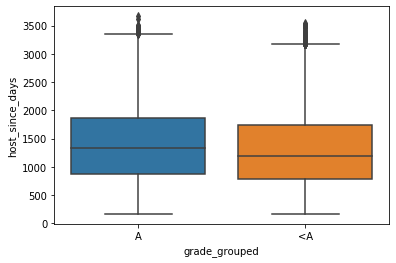

In [45]:
sns.boxplot(x='grade_grouped', y='host_since_days', data=df_logistic)

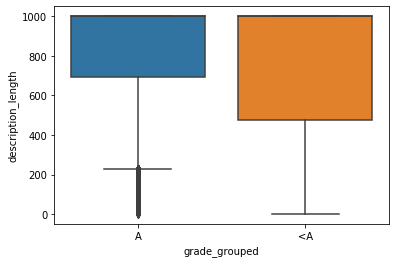

In [46]:
sns.boxplot(x='grade_grouped', y='description_length', data=df_logistic)

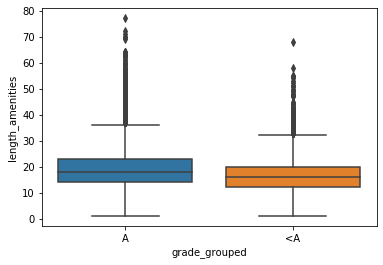

In [47]:
sns.boxplot(x='grade_grouped', y='length_amenities', data=df_logistic)

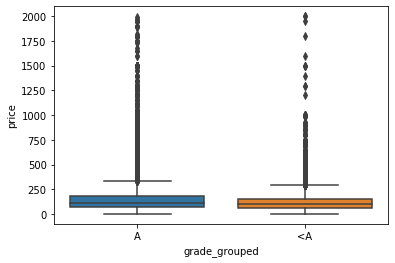

In [48]:
sns.boxplot(x='grade_grouped', y='price', data=df_logistic)

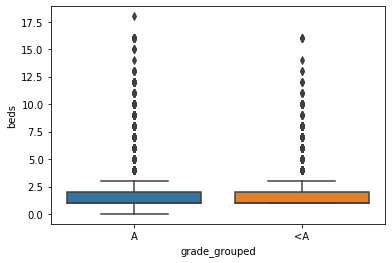

In [49]:
sns.boxplot(x='grade_grouped', y='beds', data=df_logistic)

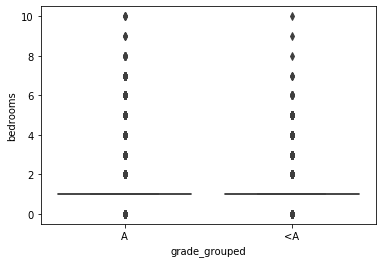

In [50]:
sns.boxplot(x='grade_grouped', y='bedrooms', data=df_logistic)

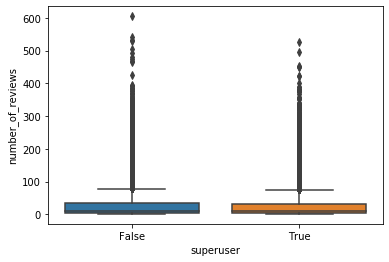

In [51]:
sns.boxplot(x='superuser', y='number_of_reviews', data=df_logistic)

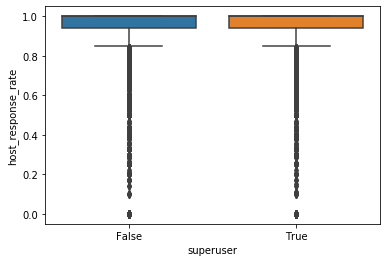

In [52]:
sns.boxplot(x='superuser', y='host_response_rate', data=df_logistic)

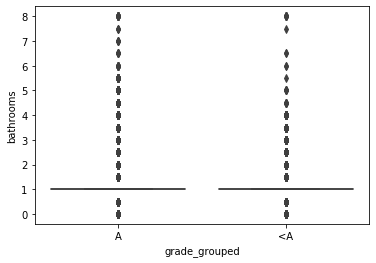

In [53]:
sns.boxplot(x='grade_grouped', y='bathrooms', data=df_logistic)

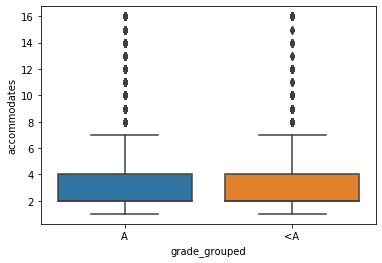

In [54]:
sns.boxplot(x='grade_grouped', y='accommodates', data=df_logistic)

# Look at collinearity

In [40]:
numerics = ['int64', 'float64']
df_corr = df_logistic.select_dtypes(include=numerics)
df_corr.head()

accommodates  bathrooms  host_response_rate  number_of_reviews  bedrooms  \
0             3        1.0            0.924026                  2         1   
1             7        1.0            1.000000                  6         3   
2             5        1.0            1.000000                 10         1   
3             2        1.0            1.000000                  4         0   
4             2        1.0            1.000000                  3         1   

   beds  price  length_amenities  description_length  host_since_days  
0     1  150.0                 9                 211             2179  
1     3  169.0                15                1000              268  
2     3  145.0                19                1000              505  
3     1  115.0                12                 699             1109  
4     1   85.0                10                1000              280

In [41]:
df_corr.corr()

accommodates  bathrooms  host_response_rate  \
accommodates            1.000000   0.498232            0.047379   
bathrooms               0.498232   1.000000            0.018456   
host_response_rate      0.047379   0.018456            1.000000   
number_of_reviews       0.031000  -0.040912            0.117379   
bedrooms                0.720385   0.574308            0.027709   
beds                    0.824703   0.513076            0.047577   
price                   0.579029   0.490656            0.001935   
length_amenities        0.258958   0.161037            0.131337   
description_length      0.116491   0.044418            0.099819   
host_since_days        -0.018579  -0.006523           -0.019037   

                    number_of_reviews  bedrooms      beds     price  \
accommodates                 0.031000  0.720385  0.824703  0.579029   
bathrooms                   -0.040912  0.574308  0.513076  0.490656   
host_response_rate           0.117379  0.027709  0.047577  0.001935   
number_of_reviews            1.000000 -0.038597  0.022787 -0.044057   
bedrooms                    -0.038597  1.000000  0.704858  0.551253   
beds                         0.022787  0.704858  1.000000  0.491563   
price                       -0.044057  0.551253  0.491563  1.000000   
length_amenities             0.144332  0.182850  0.229713  0.191038   
description_length           0.227540  0.082153  0.092062  0.062491   
host_since_days              0.201491  0.015285 -0.031468  0.051808   

                    length_amenities  description_length  host_since_days  
accommodates                0.258958            0.116491        -0.018579  
bathrooms                   0.161037            0.044418        -0.006523  
host_response_rate          0.131337            0.099819        -0.019037  
number_of_reviews           0.144332            0.227540         0.201491  
bedrooms                    0.182850            0.082153         0.015285  
beds                        0.229713            0.092062        -0.031468  
price                       0.191038            0.062491         0.051808  
length_amenities            1.000000            0.269240        -0.038405  
description_length          0.269240            1.000000         0.185753  
host_since_days            -0.038405            0.185753         1.000000

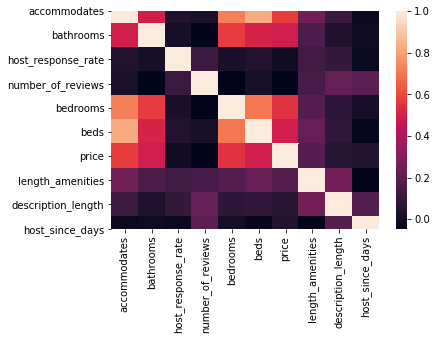

In [42]:
# no strong correlations between numerical variables
# rule of thumnb: correlation above 0.9 is problematic
sns.heatmap(df_corr.corr())
plt.show()

# Correlations between categorical variables and Numeric Variables
* will use ANOVA

In [43]:
import scipy.stats as stats

numerical_vars = list(df_logistic.select_dtypes(include=numerics).columns)
print(numerical_vars)

categorical_vars = list(df_logistic.select_dtypes(include=['category', 'bool']).columns)

print(categorical_vars)

['accommodates', 'bathrooms', 'host_response_rate', 'number_of_reviews', 'bedrooms', 'beds', 'price', 'length_amenities', 'description_length', 'host_since_days']
['room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'grade', 'internet', 'TV', 'air_conditioning', 'kitchen', 'pool', 'parking', 'superuser']


#### Room type

In [44]:
#room_type is redundant
for var in numerical_vars:
    print(var, ': ')
    print(stats.f_oneway(df_logistic[var][df_logistic.room_type == 'Entire home/apt'], 
               df_logistic[var][df_logistic.room_type == 'Private room'],
               df_logistic[var][df_logistic.room_type == 'Shared room']))
    print()

accommodates : 
F_onewayResult(statistic=8311.260477381162, pvalue=0.0)

bathrooms : 
F_onewayResult(statistic=533.6824644984207, pvalue=2.2584378027609e-230)

host_response_rate : 
F_onewayResult(statistic=9.872934792213272, pvalue=5.163883408700995e-05)

number_of_reviews : 
F_onewayResult(statistic=25.88832682111481, pvalue=5.779784393585306e-12)

bedrooms : 
F_onewayResult(statistic=1791.7812374495722, pvalue=0.0)

beds : 
F_onewayResult(statistic=4317.176705064991, pvalue=0.0)

price : 
F_onewayResult(statistic=6820.273716593953, pvalue=0.0)

length_amenities : 
F_onewayResult(statistic=699.812004414434, pvalue=5.280719624892653e-301)

description_length : 
F_onewayResult(statistic=200.5409063304744, pvalue=1.6186136413727302e-87)

host_since_days : 
F_onewayResult(statistic=143.9161079301942, pvalue=4.51081762544199e-63)



#### Bed_type

In [45]:
for var in numerical_vars:
    print(var, ': ')
    print(stats.f_oneway(df_logistic[var][df_logistic.bed_type == 'Real Bed'], 
               df_logistic[var][df_logistic.bed_type == 'Futon'],
               df_logistic[var][df_logistic.bed_type == 'Pull-out Sofa'],
              df_logistic[var][df_logistic.bed_type == 'Couch'],
              df_logistic[var][df_logistic.bed_type == 'Airbed']))
    print()
    

accommodates : 
F_onewayResult(statistic=102.04947044326022, pvalue=9.630281590057128e-87)

bathrooms : 
F_onewayResult(statistic=27.904042696251405, pvalue=3.467200673340659e-23)

host_response_rate : 
F_onewayResult(statistic=2.353563913070348, pvalue=0.05155216075667624)

number_of_reviews : 
F_onewayResult(statistic=8.51600176921841, pvalue=7.262564854627648e-07)

bedrooms : 
F_onewayResult(statistic=60.372615039866616, pvalue=5.684462709636918e-51)

beds : 
F_onewayResult(statistic=74.1156356502596, pvalue=9.148265945184976e-63)

price : 
F_onewayResult(statistic=71.49261792865688, pvalue=1.6319097372406637e-60)

length_amenities : 
F_onewayResult(statistic=20.4191984055442, pvalue=7.901181515252077e-17)

description_length : 
F_onewayResult(statistic=10.248095157947763, pvalue=2.7155721454553722e-08)

host_since_days : 
F_onewayResult(statistic=14.19936597869075, pvalue=1.3822950226623125e-11)



#### Cancellation policy

In [46]:
for var in numerical_vars:
    print(var, ': ')
    print(stats.f_oneway(df_logistic[var][df_logistic.cancellation_policy == 'strict'], 
               df_logistic[var][df_logistic.cancellation_policy == 'moderate'],
               df_logistic[var][df_logistic.cancellation_policy == 'flexible'],
              df_logistic[var][df_logistic.cancellation_policy == 'super_strict_30'],
              df_logistic[var][df_logistic.cancellation_policy == 'super_strict_60']))
    print()
    

accommodates : 
F_onewayResult(statistic=625.362058848526, pvalue=0.0)

bathrooms : 
F_onewayResult(statistic=163.58453704084602, pvalue=1.688385471521771e-139)

host_response_rate : 
F_onewayResult(statistic=127.82475818932434, pvalue=7.413989514035901e-109)

number_of_reviews : 
F_onewayResult(statistic=388.6685401492283, pvalue=0.0)

bedrooms : 
F_onewayResult(statistic=303.0969869499843, pvalue=1.7788969602946338e-258)

beds : 
F_onewayResult(statistic=483.00142177331134, pvalue=0.0)

price : 
F_onewayResult(statistic=458.6254579107413, pvalue=0.0)

length_amenities : 
F_onewayResult(statistic=517.9927741542882, pvalue=0.0)

description_length : 
F_onewayResult(statistic=944.3057366911261, pvalue=0.0)

host_since_days : 
F_onewayResult(statistic=280.14155062709756, pvalue=5.731773057493463e-239)



Anova seems to be overly sensitive to finding correlations. I will stop here

# Correlations between categorical variables
* Use Cramers V for correlation between categorical variables. It ranges from 0 (no association) to 1 (strong association)

In [54]:
import scipy.stats as ss

In [55]:
categorical_vars = ['room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic',
                   'host_identity_verified', 'instant_bookable', 'internet', 'TV', 'air_conditioning',
                   'kitchen', 'pool', 'parking']

df_logistic_correlation = df_logistic[categorical_vars]

In [56]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [57]:
for var in categorical_vars:
    print('The association of {} with the following variables is'.format(var))
    for var2 in categorical_vars:
        confusion_matrix = pd.crosstab(df_logistic_correlation[var], df_logistic_correlation[var2]).as_matrix()
        print(var2, ': ', cramers_v(df_logistic[var], df_logistic[var2]))
    print()

The association of room_type with the following variables is
room_type :  1.0
bed_type :  0.1793748065380461
cancellation_policy :  0.1220019589589836
cleaning_fee :  0.21826793323473284
city :  0.08172005270469712
host_has_profile_pic :  0.0
host_identity_verified :  0.05153835232246948
instant_bookable :  0.032603183603628745
internet :  0.05601238730062045
TV :  0.2599952029891558
air_conditioning :  0.08250167983345934
kitchen :  0.15153203675520513
pool :  0.05287497280484075
parking :  0.05222894743329889

The association of bed_type with the following variables is
room_type :  0.1793748065380461
bed_type :  1.0
cancellation_policy :  0.020333596740673206
cleaning_fee :  0.029661826563628393
city :  0.015766381325537843
host_has_profile_pic :  0.0
host_identity_verified :  0.012197281200082339
instant_bookable :  0.024833155023125213
internet :  0.023856576997351546
TV :  0.061251044773271084
air_conditioning :  0.037473028945249565
kitchen :  0.019682040308467517
pool :  0.01413

* Room type, bed type, cancellation policy, cleaning fee, having a profile pic, having your identity verified, being instant bookable,and having internet do not seem to have an any strong correlations with other variables
* City has moderate correlations with having parking, a pool, and air conditioning

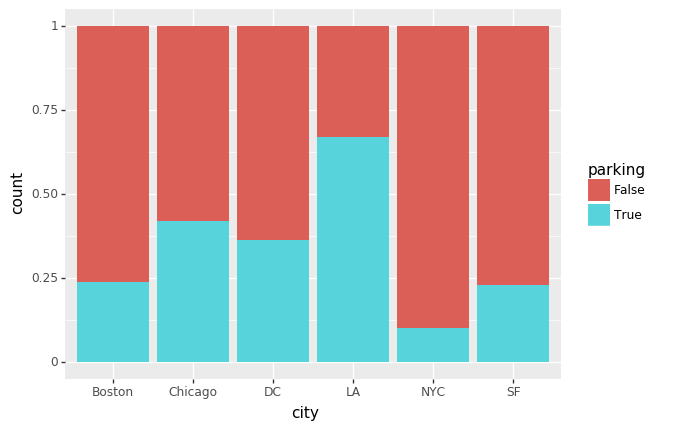

<ggplot: (7560511927)>

In [58]:
(ggplot(df_logistic, aes('city', fill='parking'))
 + geom_bar( position='fill')
)

Here we see that LA is the most likely to have parking, while NYC is the least likely to have parking

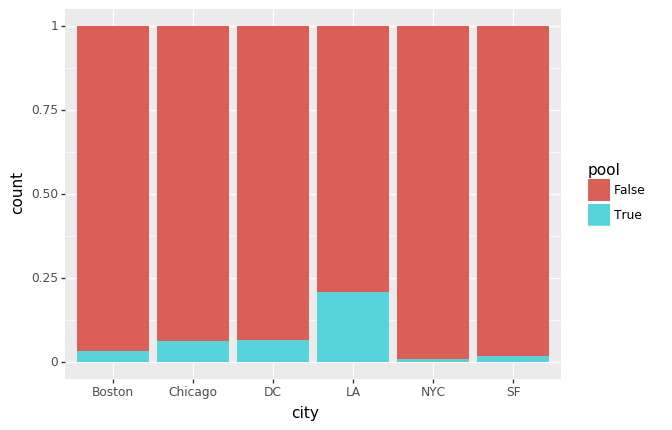

<ggplot: (7555923818)>

In [59]:
(ggplot(df_logistic, aes('city', fill='pool'))
 + geom_bar( position='fill')
)

Here we see that an LA property is the most likely to have a pool.

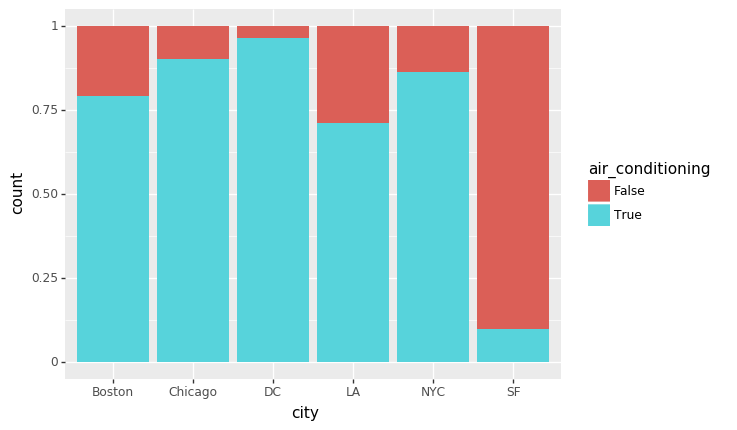

<ggplot: (7554978147)>

In [61]:
(ggplot(df_logistic, aes('city', fill='air_conditioning'))
 + geom_bar( position='fill')
)

Here we see that having AC is common in all the cities except San Francisco, where it is uncommon.

## Logistic Regression (Ridge, Scaling)

In [65]:
# Create dummy variables
categorical_vars = ['parking', 'pool', 'kitchen', 'air_conditioning', 'TV', 'internet', 'instant_bookable',
                   'host_identity_verified', 'host_has_profile_pic', 'city', 'cleaning_fee', 'cancellation_policy',
                   'bed_type', 'room_type']

dummy_df = pd.get_dummies(df_logistic[categorical_vars], drop_first=True)

df_logistic_dummy = pd.concat([df_logistic, dummy_df], axis=1)

df_logistic_dummy.head()

room_type  accommodates  bathrooms  bed_type cancellation_policy  \
0  Entire home/apt             3        1.0  Real Bed              strict   
1  Entire home/apt             7        1.0  Real Bed              strict   
2  Entire home/apt             5        1.0  Real Bed            moderate   
3  Entire home/apt             2        1.0  Real Bed            moderate   
4     Private room             2        1.0  Real Bed              strict   

   cleaning_fee city first_review  host_has_profile_pic  \
0          True  NYC   2016-06-18                  True   
1          True  NYC   2017-08-05                  True   
2          True  NYC   2017-04-30                  True   
3          True   DC   2015-05-12                  True   
4          True   SF   2017-08-27                  True   

   host_identity_verified  host_response_rate host_since  instant_bookable  \
0                    True            0.924026 2012-03-26             False   
1                   False            1.000000 2017-06-19              True   
2                    True            1.000000 2016-10-25              True   
3                    True            1.000000 2015-03-01              True   
4                    True            1.000000 2017-06-07              True   

  last_review  number_of_reviews  bedrooms  beds  price grade  \
0  2016-07-18                  2         1     1  150.0     A   
1  2017-09-23                  6         3     3  169.0     A   
2  2017-09-14                 10         1     3  145.0     A   
3  2017-01-22                  4         0     1  115.0     F   
4  2017-09-05                  3         1     1   85.0     A   

                                       amenities_new  length_amenities  \
0  [wireless internet, air conditioning, kitchen,...                 9   
1  [wireless internet, air conditioning, kitchen,...                15   
2  [tv, cable tv, wireless internet, air conditio...                19   
3  [tv, internet, wireless internet, air conditio...                12   
4  [tv, wireless internet, heating, smoke detecto...                10   

   internet     TV  air_conditioning  kitchen   pool  parking  \
0      True  False              True     True  False    False   
1      True  False              True     True  False    False   
2      True   True              True     True  False    False   
3      True   True              True     True  False    False   
4      True   True             False    False  False    False   

   description_length  superuser grade_grouped  host_since_days  parking  \
0                 211       True             A             2179    False   
1                1000      False             A              268    False   
2                1000      False             A              505    False   
3                 699      False            <A             1109    False   
4                1000      False             A              280    False   

    pool  kitchen  air_conditioning     TV  internet  instant_bookable  \
0  False     True              True  False      True             False   
1  False     True              True  False      True              True   
2  False     True              True   True      True              True   
3  False     True              True   True      True              True   
4  False    False             False   True      True              True   

   host_identity_verified  host_has_profile_pic  cleaning_fee  city_Chicago  \
0                    True                  True          True             0   
1                   False                  True          True             0   
2                    True                  True          True             0   
3                    True                  True          True             0   
4                    True                  True          True             0   

   city_DC  city_LA  city_NYC  city_SF  cancellation_policy_moderate  \
0        0        0         1        0        

In [66]:
#delete categorical variables
for x in categorical_vars:
    if x in df_logistic_dummy:
        del df_logistic_dummy[x]

df_logistic_dummy.head()

accommodates  bathrooms first_review  host_response_rate host_since  \
0             3        1.0   2016-06-18            0.924026 2012-03-26   
1             7        1.0   2017-08-05            1.000000 2017-06-19   
2             5        1.0   2017-04-30            1.000000 2016-10-25   
3             2        1.0   2015-05-12            1.000000 2015-03-01   
4             2        1.0   2017-08-27            1.000000 2017-06-07   

  last_review  number_of_reviews  bedrooms  beds  price grade  \
0  2016-07-18                  2         1     1  150.0     A   
1  2017-09-23                  6         3     3  169.0     A   
2  2017-09-14                 10         1     3  145.0     A   
3  2017-01-22                  4         0     1  115.0     F   
4  2017-09-05                  3         1     1   85.0     A   

                                       amenities_new  length_amenities  \
0  [wireless internet, air conditioning, kitchen,...                 9   
1  [wireless internet, air conditioning, kitchen,...                15   
2  [tv, cable tv, wireless internet, air conditio...                19   
3  [tv, internet, wireless internet, air conditio...                12   
4  [tv, wireless internet, heating, smoke detecto...                10   

   description_length  superuser grade_grouped  host_since_days  city_Chicago  \
0                 211       True             A             2179             0   
1                1000      False             A              268             0   
2                1000      False             A              505             0   
3                 699      False            <A             1109             0   
4                1000      False             A              280             0   

   city_DC  city_LA  city_NYC  city_SF  cancellation_policy_moderate  \
0        0        0         1        0                             0   
1        0        0         1        0                             0   
2        0        0         1        0                             1   
3        1        0         0        0                             1   
4        0        0         0        1                             0   

   cancellation_policy_strict  cancellation_policy_super_strict_30  \
0                           1                                    0   
1                           1                                    0   
2                           0                                    0   
3                           0                                    0   
4                           1                                    0   

   cancellation_policy_super_strict_60  bed_type_Couch  bed_type_Futon  \
0                                    0               0               0   
1                                    0               0               0   
2                                    0               0               0   
3                                    0               0               0   
4                                    0               0               0   

   bed_type_Pull-out Sofa  bed_type_Real Bed  room_type_Private room  \
0                       0                  1                       0   
1                       0                  1                       0   
2                       0                  1                       0   
3                       0                  1                       0   
4                       0                  1                       1   

   room_type_Shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

In [67]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57388 entries, 0 to 57388
Data columns (total 31 columns):
room_type                 57388 non-null category
accommodates              57388 non-null int64
bathrooms                 57388 non-null float64
bed_type                  57388 non-null category
cancellation_policy       57388 non-null category
cleaning_fee              57388 non-null bool
city                      57388 non-null category
first_review              57388 non-null datetime64[ns]
host_has_profile_pic      57388 non-null bool
host_identity_verified    57388 non-null bool
host_response_rate        57388 non-null float64
host_since                57388 non-null datetime64[ns]
instant_bookable          57388 non-null bool
last_review               57388 non-null datetime64[ns]
number_of_reviews         57388 non-null int64
bedrooms                  57388 non-null int64
beds                      57388 non-null int64
price                     57388 non-null float64
grad

In [68]:
#delete amenities_new because used to create other variables
del df_logistic_dummy['amenities_new']

#delete host_since because used to create host_since_days
del df_logistic_dummy['host_since']

#delete grade and superuser because redundant with grouped_grade
del df_logistic_dummy['grade']
del df_logistic_dummy['superuser']

In [69]:
#remove timestamps
del df_logistic_dummy['first_review']
del df_logistic_dummy['last_review']

df_logistic_dummy.head()

accommodates  bathrooms  host_response_rate  number_of_reviews  bedrooms  \
0             3        1.0            0.924026                  2         1   
1             7        1.0            1.000000                  6         3   
2             5        1.0            1.000000                 10         1   
3             2        1.0            1.000000                  4         0   
4             2        1.0            1.000000                  3         1   

   beds  price  length_amenities  description_length grade_grouped  \
0     1  150.0                 9                 211             A   
1     3  169.0                15                1000             A   
2     3  145.0                19                1000             A   
3     1  115.0                12                 699            <A   
4     1   85.0                10                1000             A   

   host_since_days  city_Chicago  city_DC  city_LA  city_NYC  city_SF  \
0             2179             0        0        0         1        0   
1              268             0        0        0         1        0   
2              505             0        0        0         1        0   
3             1109             0        1        0         0        0   
4              280             0        0        0         0        1   

   cancellation_policy_moderate  cancellation_policy_strict  \
0                             0                           1   
1                             0                           1   
2                             1                           0   
3                             1                           0   
4                             0                           1   

   cancellation_policy_super_strict_30  cancellation_policy_super_strict_60  \
0                                    0                                    0   
1                                    0                                    0   
2                                    0                                    0   
3                                    0                                    0   
4                                    0                                    0   

   bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  \
0               0               0                       0                  1   
1               0               0                       0                  1   
2               0               0                       0                  1   
3               0               0                       0                  1   
4               0               0                       0                  1   

   room_type_Private room  room_type_Shared room  
0                       0                      0  
1                       0                      0  
2                       0                      0  
3                       0                      0  
4                       1                      0

In [70]:
X = df_logistic_dummy.drop(['grade_grouped'], axis=1).values
y = df_logistic_dummy['grade_grouped'].values

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split

# Scale data
scl = StandardScaler()
logistic_scaled = scl.fit_transform(X)

#split the data, stratifying on grade
X_train, X_test, y_train, y_test = train_test_split(logistic_scaled, y,
                                                    stratify=y, 
                                                    test_size=0.25, random_state=0)


#Ridge lasso regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) 
clf.fit(X_train, y_train)

#accuracy
print(clf.score(X_test, y_test))

predictions = clf.predict(X_test)

#columns is the actual value, while rows are the predicted category
#there are alot of times where A was predicted but the actual value was B and lower 
print(pd.crosstab(predictions, y_test))

0.8328570432843103
col_0    <A      A
row_0             
<A       27     52
A      2346  11922


Here we can see that out accuracy is high (83.3%), but it is overly inflated due to the class imbalance. The model is not good at predicting a property that will let lower than A. The model has a lot of false negatives, where it should have predicted <A, but instead predicted an A.

# Look at coefficients

In [74]:
# Look at coefficients

import statsmodels.api as sm

y_sm = pd.Series(y).map({'A':1, '<A':0})

X_sm = pd.DataFrame(X, columns = df_logistic_dummy.drop(['grade_grouped'], axis=1).columns)
X_sm = sm.add_constant(X_sm)

X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, train_size = 0.8, random_state=0)

logit = sm.Logit(y_sm_train, X_sm_train)

result = logit.fit()

#bed type not significant
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.424002
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                45910
Model:                          Logit   Df Residuals:                    45884
Method:                           MLE   Df Model:                           25
Date:                Sun, 27 Oct 2019   Pseudo R-squ.:                 0.05654
Time:                        20:49:51   Log-Likelihood:                -19466.
converged:                       True   LL-Null:                       -20633.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.6825      0.203 

In [76]:
y_sm = df_logistic_dummy['grade_grouped'].map({'A':1, '<A':0})
X_sm = df_logistic_dummy.drop(['grade_grouped', 'bed_type_Couch', 'bed_type_Futon',
                                                        'bed_type_Pull-out Sofa', 'bed_type_Real Bed'], axis=1)
X_sm = sm.add_constant(X_sm)

X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, train_size = 0.8, random_state=0)

logit = sm.Logit(y_sm, X_sm)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.423927
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          grade_grouped   No. Observations:                57388
Model:                          Logit   Df Residuals:                    57366
Method:                           MLE   Df Model:                           21
Date:                Sun, 27 Oct 2019   Pseudo R-squ.:                 0.05477
Time:                        20:50:44   Log-Likelihood:                -24328.
converged:                       True   LL-Null:                       -25738.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.7600      0.105 

All the coefficients are now significant. However, the pseudo R squared is extremely low, meaning that this is not a very good model.

In [77]:
#log likelihoods
print(np.exp(result.params))

const                                  0.467669
accommodates                           0.858665
bathrooms                              0.912909
host_response_rate                     2.533500
number_of_reviews                      1.001058
bedrooms                               1.114343
beds                                   0.935683
price                                  1.002768
length_amenities                       1.060102
description_length                     1.000441
host_since_days                        1.000170
city_Chicago                           1.855096
city_DC                                1.512701
city_LA                                1.453395
city_NYC                               1.151677
city_SF                                1.427590
cancellation_policy_moderate           1.081758
cancellation_policy_strict             0.702804
cancellation_policy_super_strict_30    0.143548
cancellation_policy_super_strict_60    0.374382
room_type_Private room                 0

# Logistic Regression with SMOTE

In [79]:
X = df_logistic_dummy.drop(['grade_grouped'], axis=1).values
y = df_logistic_dummy['grade_grouped'].values

#SMOTE: will oversample the smaller class
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

#equal counts now
pd.Series(y_train).value_counts()

clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' )
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' )
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

predictions = clf.predict(X_test)

#columns is the actual value, while rows are the predicted category
#there are alot of times where we predicted a B, but it was actually an A
pd.crosstab(predictions, y_test)

0.6163657907576496


col_0    <A     A
row_0            
<A     1491  4622
A       882  7352

With SMOTE, our overall accuracy decreased. However, we were better able to predict the below A class.

## Random Forest Task 1

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit

cv_strat_obj = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, train_size=0.8, random_state=0)
X_rf = df_final.drop(['grade_grouped'], axis=1).values
y_rf = df_final['grade_grouped'].values
cv_strat_obj.split(X_rf, y_rf)
cv_strat_obj

StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.2,
            train_size=0.8)

In [65]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
for train_index, test_index in cv_strat_obj.split(X_rf, y_rf):
    X_trainrf, X_testrf = X_rf[train_index], X_rf[test_index]
    y_trainrf, y_testrf = y_rf[train_index], y_rf[test_index]

In [66]:
rfc.fit(X_trainrf, y_trainrf) 
print(rfc.feature_importances_)

[1.23133589e-01 9.36012797e-03 1.45407923e-03 1.03862193e-02
 0.00000000e+00 1.92208474e-02 1.63135059e-01 1.08392510e-01
 5.24478382e-02 1.25728834e-03 1.29083704e-02 2.03365927e-01
 3.93355484e-02 5.89690109e-02 1.83634347e-03 1.71036042e-04
 3.02387941e-03 6.88594045e-03 4.03822204e-04 3.97605338e-02
 1.29948558e-03 0.00000000e+00 2.22716635e-03 5.08033287e-02
 2.65804388e-03 5.36703678e-02 2.10485000e-02 1.37758506e-03
 0.00000000e+00 1.20852178e-04 0.00000000e+00 0.00000000e+00
 9.57405276e-04 0.00000000e+00 1.03892950e-02]


In [67]:
rfc.predict(X_testrf)

array(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype=object)

## Random Forest Task 2

In [68]:
X_rf2 = df_superuser_subset.drop(['superuser','grade_grouped'], axis=1).values
y_rf2 = df_superuser_subset['superuser'].values
rfc2 = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
cv_strat_obj.split(X_rf2, y_rf2)

for train_index, test_index in cv_strat_obj.split(X_rf2, y_rf2):
    X_trainrf2, X_testrf2 = X_rf2[train_index], X_rf2[test_index]
    y_trainrf2, y_testrf2 = y_rf2[train_index], y_rf2[test_index]

In [69]:
rfc2.fit(X_trainrf2, y_trainrf2) 
print(rfc2.feature_importances_)

[0.14841263 0.10615858 0.11092478 0.00874375 0.01023436 0.00295108
 0.04847912 0.00326429 0.09201499 0.03641447 0.04211186 0.07982609
 0.0088096  0.0009307  0.01736351 0.00134093 0.00448196 0.02229056
 0.10322721 0.00462568 0.01188354 0.         0.01906244 0.01972843
 0.01486755 0.00448454 0.00726635 0.00229371 0.02176232 0.00969008
 0.00448594 0.00838277 0.0093121  0.01417409]


In [70]:
rfc2.predict(X_testrf2)

array([False, False, False, ..., False, False, False])

## K Nearest Neighbors

The K nearest neighbors (KNN) algorithm uses some defined distance metric to compare an unknown record to known training data and produce a classification label. Therefore, any numeric (int or float) variables are usable. Boolean attributes translate cleanly and are easily usable as well. Conversely, certain categoric variables (such as room type or city) cannot have number assignments because they would incorrectly imply order. These should be omitted or modified into boolean attributes.

Additionally, because distance is used to compare and classify data points, it's important that the attributes are on similar scales to prevent any attributes with bigger ranges from dominating. For example, the ranges for number_of_reviews and host_since_days far eclipses any boolean variables or a percentage like host_response_rate. This was taken care of in a prior processing step by scaling all numbers between 0 and 1.

In [71]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### Task 1: KNN Grade Grouping

In [72]:
%%time
for train, test in cv.split(X1,y1):
    clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', 
                               metric='euclidean')
    clf.fit(X1[train],y1[train])
    yhat1[test] = clf.predict(X1[test])
    print(precision_score(y1[test], yhat1[test]))

0.8471043895241608
0.8441225013753897
0.8456289192180008
0.8454680534918276
0.8440721649484536
0.8474043968224645
0.8449669360764144
0.8422985129429044
0.8475262093066029
0.8483900643974241
Wall time: 7min 27s


In [78]:
%%time

# Attempt at GridSearch
# Code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

knn = KNeighborsClassifier()
parameters = {
    'n_neighbors': [1,3,5,7,9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# cv argument should perform stratified kfold
grid_knn = GridSearchCV(knn, param_grid = parameters, scoring = 'precision',
                       cv = 10, refit = 'precision')
grid_knn.fit(X1, y1)

print("Best parameter set found for traininge data:")
print(grid_knn.best_params_)

Wall time: 0 ns


In [74]:
grid_knn.best_index_

AttributeError: 'GridSearchCV' object has no attribute 'best_index_'

In [ ]:
grid_knn.cv_results_

### Task 2: KNN Superhost

In [79]:
%%time

knn = KNeighborsClassifier()
parameters_knn_super = {
    'n_neighbors': [1,3,5,7,9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

# cv argument should perform stratified kfold
grid_knn_super = GridSearchCV(knn, param_grid = parameters_knn_super, scoring = 'precision',
                      cv = 10, refit = 'precision')
grid_knn_super.fit(X2, y2)

print("Best parameter set found for training data:")
print(grid_knn_super.best_params_)

Wall time: 0 ns


In [ ]:
grid_knn_super.best_index_

In [ ]:
grid_knn_super.cv_results_

***

# Modeling and Evaluation 4

<i><b>10 pts.</b> Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.</i>

# Random Forest Evaluation

Let's first check the accuracy of our random forest model for task one - this random forest permutates a number of decisions that could lead to a host receiving an A grade. 

In [80]:
rfc.score(X_testrf, y_testrf)

0.8346401812162397

This model generates an accuracy of 83.464%; however, this is not the only important metric from this model. Since this is an imbalanced classification, we should examine metrics that are insenstive to such imbalances. An ROC curve and AUC will suffice to demonstract if the accuracy belies an undesirable false positive rate, which would indicate poor precision.

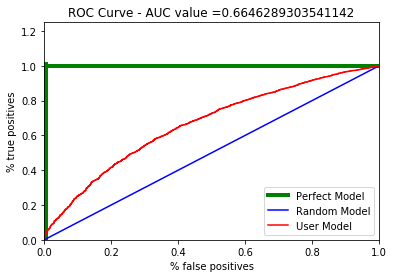

In [81]:
from sklearn.metrics import roc_curve, auc


y_preds_proba = rfc.predict_proba(X=X_testrf)
fpr, tpr, thresholds = roc_curve(y_testrf, y_preds_proba[:,1], pos_label='A')
xx = np.arange(101) / float(100)
rfc_auc = auc(fpr,tpr)

plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot([0.0, 0.0], [0.0, 1.0], color='green', linewidth=8)
plt.plot([0.0, 1.0], [1.0, 1.0], color='green', label='Perfect Model', linewidth=4)
plt.plot(xx,xx, color='blue', label='Random Model')
plt.plot(fpr,tpr, color='red', label='User Model')
plt.title("ROC Curve - AUC value ="+str(rfc_auc))
plt.xlabel('% false positives')
plt.ylabel('% true positives')
plt.legend()
plt.show()

With an AUC of 0.6646, it appears our model has some capacity for class separation but not an extraordinary amount. In particular, higher accuracy generates higher false positive values, something to keep in mind if this model is taken to production. Finally, let's plot our feature importances.

In [82]:
rfc2.score(X_testrf2, y_testrf2)

0.5753653444676409

Much less accurate model at 57.537% accuracy. Again, this is not the complete picture - the ROC curve and AUC score will indicate if there is a precision tradeoff.

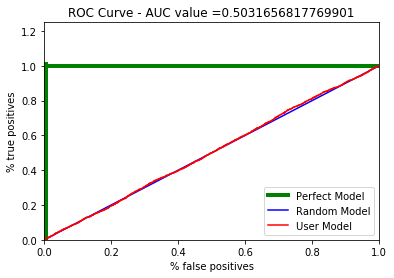

In [83]:
y_preds_proba2 = rfc2.predict_proba(X=X_testrf2)
fpr2, tpr2, thresholds = roc_curve(y_testrf2, y_preds_proba2[:,1], pos_label=True)
xx = np.arange(101) / float(100)
rfc_auc2 = auc(fpr2,tpr2)

plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot([0.0, 0.0], [0.0, 1.0], color='green', linewidth=8)
plt.plot([0.0, 1.0], [1.0, 1.0], color='green', label='Perfect Model', linewidth=4)
plt.plot(xx,xx, color='blue', label='Random Model')
plt.plot(fpr2,tpr2, color='red', label='User Model')
plt.title("ROC Curve - AUC value ="+str(rfc_auc2))
plt.xlabel('% false positives')
plt.ylabel('% true positives')
plt.legend()
plt.show()

With an AUC score very close to .5, this model has almost no capacity to distinguish positive classes. In other words, this random forest method behaves similar to a random state, and generates nearly as many false positives as true positives. Some insights into feature importance could indicate the reason for this. 

## KNN

In [84]:
# Task 1: Grade grouping
knn_scores_list = list(zip(grid_knn.cv_results_['params'], grid_knn.cv_results_['mean_test_score'],
                          grid_knn.cv_results_['std_test_score'], grid_knn.cv_results_['rank_test_score'])) 

knn_scores_pd = pd.DataFrame(knn_scores_list, columns = ['Parameter Set', 'Mean Test Score',
                                                        'STD Test Score', 'Rank'])
knn_scores_pd.sort_values(by=['Rank']).head(10)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [85]:
# Task 2: Superhost
knn_scores_super_list = list(zip(grid_knn_super.cv_results_['params'], grid_knn_super.cv_results_['mean_test_score'],
                          grid_knn_super.cv_results_['std_test_score'], grid_knn_super.cv_results_['rank_test_score'])) 

knn_scores_super_pd = pd.DataFrame(knn_scores_super_list, columns = ['Parameter Set', 'Mean Test Score',
                                                        'STD Test Score', 'Rank'])
knn_scores_super_pd.sort_values(by=['Rank']).head(10)

NameError: name 'grid_knn_super' is not defined

In [ ]:
plt.bar(range(len(grid_knn.cv_results_['params'])), grid_knn.cv_results_['mean_test_score'])
plt.title('KNN Task 1: 10-Fold CV Scores')
plt.xlabel('Parameter Set Index')
plt.ylabel('Mean Precision')
plt.show()

In [ ]:
plt.bar(range(len(grid_knn_super.cv_results_['params'])), grid_knn_super.cv_results_['mean_test_score'])
plt.title('KNN Task 2: 10-Fold CV Scores')
plt.xlabel('Parameter Set Index')
plt.ylabel('Mean Precision')
plt.show()

GridSearch for KNN resulted in a best mean precision of 0.85318 for Task 1 and 0.431041 for Task 2. Despite the graphs above having similar shapes, the y-axis ranges reveal that KNN performed rather poorly on Task 2 for some reason. It's notable that the bar heights within each chart are relatively similar. Tuning the parameters within each model by changing things such as the algorithm or value of K resulted in very minor increases of predictive power on the test folds. 

In lieu of a scree plot on K alone, the top rows in the GridSearch tables tell the story that, even with other parameters in the sets changing, certain values of K seemed to be most optimal for each task. In particular, all eight sets using K=1 swept the highest mean precision scores for Task 1, meaning that those models only considered the closest neighbor to make a classification decision. Meanwhile, Task 2 had its highest mean precision scores with K=3.

***

# Modeling and Evaluation 5

<i><b>10 pts.</b> Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniquesâ€”be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.</i>

Most advantages and disadvantages of the random forest model are the same as found in this method in general - it could easily be re-trained on any sample. If we were to localize the sample to a different city or type of listing this model would translate well; however, the accuracy and precision would be about the same regardless of the data. As we saw, the precision was not great, especially on task 2 (close to random state with AUC of ~.5). So while this method would be computationally efficient and easy to scale, it would also generate very imprecise responses, especially where superhosts are concerned.

In [ ]:
#focus on precision with f measure, p test, check 7.17 module

<font color='red'>Logistic Regression has the advantage of giving coefficients, which can be interpretted as log odds and also give probabilities for a certain combination of variables. However, even though all our coefficients were significant in the logistic regression model, our overall model did a terrible job of predicting the below A class due to the class imbalance. </font>

For KNN, predictive performance for the grade classification task was approximately on par with logistic regression; the best mean precision on a 10-fold cross-validation given the grid of available parameters was 0.85317. However, performance on the superhost classification task was distinctly worse, with the best mean precision being only 0.43104.

Mean accuracy of Random Forest for task 1 is  0.8346024541652115
Mean accuracy of Logistic Regression for task 1 is  0.8338880136253032
Mean accuracy of KNN for task 1 is  0.819442830275047


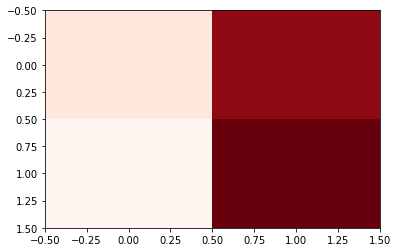

In [90]:
#task 1
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

cv=StratifiedKFold(n_splits=10)
models_and_accuracy = []
acc1 = cross_val_score(rfc, X1, y=y1, cv=cv)
acc2 = cross_val_score(lr_clf, X1, y=y1, cv=cv)
acc3 = cross_val_score(clf, X1, y=y1, cv=cv)

#=================================

print ('Mean accuracy of Random Forest for task 1 is ',np.mean(acc1))
print ('Mean accuracy of Logistic Regression for task 1 is ',np.mean(acc2))
print ('Mean accuracy of KNN for task 1 is ',np.mean(acc3))

#===============================
cm = confusion_matrix(y1, yhat1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

In [91]:
#Confidence intervals for task 1

t = 2.26 / np.sqrt(10)

e1 = (1-acc1)-(1-acc2)
e2 = (1-acc2)-(1-acc3)
e3 = (1-acc1)-(1-acc3)

stdtot1 = np.std(e1)
stdtot2 = np.std(e2)
stdtot3 = np.std(e3)

dbar = np.mean(e)
print ('CI for Random Forest/Logistic Regression Comparison, Task 1:', dbar-t*stdtot1,dbar+t*stdtot1 )
print ('CI for Logistic Regression/KNN Comparison, Task 1:', dbar-t*stdtot2,dbar+t*stdtot2 )
print ('CI for Random Forest/KNN Comparison, Task 1:', dbar-t*stdtot3,dbar+t*stdtot3)

CI for Random Forest/Logistic Regression Comparison, Task 1: -0.0008739483631222995 0.0007069599089596686
CI for Logistic Regression/KNN Comparison, Task 1: -0.0027891838595965612 0.0026221954054339303
CI for Random Forest/KNN Comparison, Task 1: -0.002583418696721687 0.002416430242559056


As we had mentioned before, we are using 10 fold stratified cross validation on these models to account for the imbalanced classifications. With accuracies between 81 and 83% for each model, it would appear that each of these models performs similarly across each fold. Confidence intervals confirm this, which each comparison being very narrow and containing 0.

Mean accuracy of Random Forest for task 2 is  0.5753596256853133
Mean accuracy of Logistic Regression for task 2 is  0.575276131458232
Mean accuracy of KNN for task 2 is  0.5252313781238965


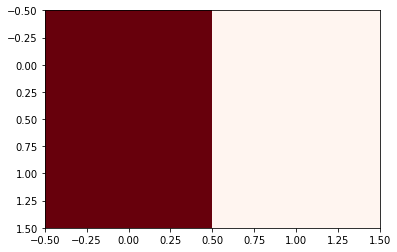

In [92]:
#confidence intervals for task 2
cv=StratifiedKFold(n_splits=10)
acc1 = cross_val_score(rfc2, X2, y=y2, cv=cv)
acc2 = cross_val_score(lr_clf, X2, y=y2, cv=cv)
acc3 = cross_val_score(knn, X2, y=y2, cv=cv)

#=================================

print ('Mean accuracy of Random Forest for task 2 is ',np.mean(acc1))
print ('Mean accuracy of Logistic Regression for task 2 is ',np.mean(acc2))
print ('Mean accuracy of KNN for task 2 is ',np.mean(acc3))

#===============================
cm = confusion_matrix(y2, yhat2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

In [93]:
t = 2.26 / np.sqrt(10)

e1 = (1-acc1)-(1-acc2)
e2 = (1-acc2)-(1-acc3)
e3 = (1-acc1)-(1-acc3)

stdtot1 = np.std(e1)
stdtot2 = np.std(e2)
stdtot3 = np.std(e3)

dbar = np.mean(e)
print ('CI for Random Forest/Logistic Regression Comparison, Task 2:', dbar-t*stdtot1,dbar+t*stdtot1 )
print ('CI for Logistic Regression/KNN Comparison, Task 2:', dbar-t*stdtot2,dbar+t*stdtot2 )
print ('CI for Random Forest/KNN Comparison, Task 2:', dbar-t*stdtot3,dbar+t*stdtot3)

CI for Random Forest/Logistic Regression Comparison, Task 2: -0.0003259258782750585 0.00015893742411242752
CI for Logistic Regression/KNN Comparison, Task 2: -0.004214691647287848 0.004047703193125217
CI for Random Forest/KNN Comparison, Task 2: -0.004207252107936817 0.004040263653774186


We see a similar case in task 2. While there appears to be a larger discrepancy in performance when comparing KNN to the rest of the models, it is not large enough to be statistically significant, as both CI's contain 0 when compared to the other two models.

***

# Modeling and Evaluation 6

<i><b>10 pts.</b> Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.</i>

In [ ]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_testrf.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_testrf.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_testrf.shape[1]), indices)
plt.xlim([-1, X_testrf.shape[1]])
plt.show()

feature_df = df_final.drop(['grade_grouped'],axis=1)
important_features = pd.Series(data=rfc.feature_importances_,index=feature_df.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

It appears that four of our features such as the description of amenities, responsiveness of the host, and of course the price, are informative of the model, while the rest are less so. Let's examine the other model. Task 2 involves subsetting the A grade and determining the probability a user will become a superuser (grade 96 or higher). We used the same type of model, so let's gather similar metrics.

In [ ]:
importances = rfc2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_testrf2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_testrf2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_testrf2.shape[1]), indices)
plt.xlim([-1, X_testrf2.shape[1]])
plt.show()

feature_df = df_final.drop(['superuser','grade_grouped'],axis=1)
important_features = pd.Series(data=rfc2.feature_importances_,index=feature_df.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

Feature 0, confirmed to be log_price has considerable leverage, with several features such as bathrooms and number of accommodations, as well as the hosts length of activity and number of reviews having roughly even importances. With this many features with roughly even mean accuracy decreases, it's hard to say if any one feature could influence the model. Given all this information, using random forest to predict superuser status may not be feasible.

In [ ]:
#feature importance from RF, iterate/optimize K neighbors, f test on regression

<font color='red'>Logistic regression does not have explicit feature importance. A feature is considered importnat if its coefficient is significant in the logistic regression model.</font>

A downside to KNN is that the algorithm does not directly provide a way to determine feature importance. When considering distances in multidimensional space, one would need to somehow calculate which attributes have the strongest influence in similarly classified data points being located near each other. The number of neighbors to consider is very important in this regard, and using GridSearch helped identify optimal k to eke out increased predictive power. The grade task ended up with multiple optimally performing parameter sets, but their shared feature was that they all used K = 1. The superhost task, which KNN performed poorly on, landed on K = 3.

In [ ]:
# Hold space for code

***

# Deployment

<i><b>5 pts.</b> How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would you deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?</i>

In [ ]:
#clarify in class, explaining profit to shareholders (superhosts provide more to Airbnb than regular hosts, we can identify users that meet those requirements and can actively recruit for the program)

The main beneficiary for this classification exercise (particularly for the stricter superhost category, as opposed to the bucketed A grade) would likely be Airbnb itself. With their track record for exemplary service, superhosts are trusted hosts who are likely to provide guests with a great experience, thus maintaining 

Assuming that feature importance can parse out specifics, if Airbnb shared which attributes are likely predictors for superhosts (aside from those already required to earn the designation, such as maintaining a high average rating and response rate), this could also benefit hosts striving for that status by suggesting what could be improved to increase the likelihood of receiving good reviews. Potential guests would likely include superhost itself as a criterion in their search. If superhosts in their needed location are unavailable, perhaps knowing other strong predictors for a good experience, aside from rating, could give them better confidence in making a choice.

Specific feature importance revealed factors such as price, amenities, and host responsiveness to be key in a host's success on the platform. Airbnb could invest in a hosting toolkit for dedicated users, including things like determining price based on the features and amenities of the listing, and easier ways for hosts and guests to communicate. If these result in higher trustworthiness, and by extension revenue for the hosts and the company, this could be a strong return on investment for these models.

Only six particular US cities are considered in the original data. Training data from other cities, or potentially even for other countries in which Airbnb operates, should be implemented before generalizing any predictions outside of these six cities. Since the main superhost component affected by guest input is average rating, sentiment or keyword analysis on review text itself could be useful at indicating what hosts are doing right or wrong, giving them additional opportunity to improve in order to attain superhost status or avoid losing it.

Given the nature of this data, the model would likely need infrequent updates after being attuned. What constitutes a good guest experience is unlikely to change over time. The main deployment cost would likely be upfront, both with cleaning and implementing data for new locations Airbnb wants to predict on, as well as training the models. Tuning the model parameters is important for increasing predictive power, but it comes at a high potential computational cost. For instance, using GridSearch to find the optimal parameter set can take hours.

***

# Exceptional Work

<i><b>10 pts.</b> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?</i>

From the work in the regular sections outlined above, we'd like to propose the following items for consideration as exceptional work:

* Using GridSearch for KNN parameter tuning.

In addition, some experimentation with models not explicitly covered by class materials is shown below. Unless stated, these are done for the grouped grade task (using X1 and y1) only.

## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
%%time

xgb_precisions = []

# XGBoost on 10-fold CV
for train, test in cv.split(X1,y1):
    clf_xgb = XGBClassifier()
    clf_xgb.fit(X1[train],y1[train])
    yhat1[test] = clf_xgb.predict(X1[test])
    xgb_precisions.append(precision_score(y1[test], yhat1[test]))
    print(classification_report(y1[test], yhat1[test]))

In [ ]:
xgb_precisions_np = np.asarray(xgb_precisions)
xgb_precisions_np.mean()

Using a similar stratified K-fold cross validator as shown above, an untuned XGBoost model returned comparable average precision. 

Shown below is a graph of relative feature importance, which indicates that features with indices 11, 7, and 6 seemed to be the top three most important. These correspond to amenities length, being instant bookable, and host response rate, respectively. Considering that having a high grade (related to this classification task, A or <A) is a prerequisite for the superhost designation, it's not surprising that response rate, another prerequisite, also gets included. For number one, the length of the amenities a site has, this makes sense as well. Having available features useful to guests, such as Wi-Fi, air conditioning, or laundry, increases the likelihood that guests will have good experiences and will then leave good reviews.

In [ ]:
plt.bar(range(len(clf_xgb.feature_importances_)), clf_xgb.feature_importances_)
plt.show()

## Neural Networks

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

In [ ]:
%%time

percep_precisions = []
kf = KFold(n_splits=10)

for train, test in kf.split(X1):
    clf_per = Perceptron(tol=1e-3, random_state=0)
    clf_per.fit(X1[train], y1[train])
    yhat1[test] = clf_per.predict(X1[test])
    percep_precisions.append(precision_score(y1[test], yhat1[test]))
    print(classification_report(y1[test], yhat1[test]))

In [ ]:
percep_precisions_np = np.asarray(percep_precisions)
percep_precisions_np.mean()

Using a similar stratified K-fold cross validator as those implemented in the main section, a single-layer perceptron without much tuning was able to post a comparable mean precision score with a blisteringly fast time.

In [ ]:
%%time
# Backpropagation neural network
# Code adapted from https://stackoverflow.com/questions/44683197/implement-k-fold-cross-validation-in-mlpclassification-python
bpnn_precisions = []

clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,5,2),
                   random_state=1)
for train, test in kf.split(X1):
    clf_mlp.fit(X1[train], y1[train])
    yhat1[test] = clf_mlp.predict(X1[test])
    bpnn_precisions.append(precision_score(y1[test], yhat1[test]))
    print(classification_report(y1[test], yhat1[test]))

In [ ]:
bpnn_precisions_np = np.asarray(bpnn_precisions)
bpnn_precisions_np.mean()

An attempt at a neural network using an ordinary backpropagation learning algorithm returns a similar, though slightly lower average precision. This could likely be improved with dedicated parameter tuning.

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [ ]:
clf_gnb = GaussianNB()
clf_mnb = MultinomialNB(alpha=0.001)
clf_bnb = BernoulliNB(alpha=0.001)

gnb_precisions = []
mnb_precisions = []
bnb_precisions = []

# GaussianNB
for train, test in kf.split(X1):
    clf_gnb.fit(X1[train], y1[train])
    yhat1[test] = clf_gnb.predict(X1[test])
    gnb_precisions.append(precision_score(y1[test], yhat1[test]))

# MultinomialNB results in error due to a negative value in X1?
# for train, test in kf.split(X1):
#     clf_mnb.fit(X1[train], y1[train])
#     yhat1[test] = clf_mnb.predict(X1[test])
#     mnb_precisions.append(precision_score(y1[test], yhat1[test]))

# BernoulliNB
for train, test in kf.split(X1):
    clf_bnb.fit(X1[train], y1[train])
    yhat1[test] = clf_bnb.predict(X1[test])
    bnb_precisions.append(precision_score(y1[test], yhat1[test]))

In [ ]:
gnb_precisions_np = np.asarray(gnb_precisions)
gnb_precisions_np.mean()

In [ ]:
bnb_precisions_np = np.asarray(bnb_precisions)
bnb_precisions_np.mean()

Gaussian Naive Bayes and Bernoulli Naive Bayes also produced similar mean precisions, at approximately 0.84.